>> Click en Run All ^^



#### Disolución de Áreas del Censo

En el procesamiento geoespacial, la disolución es un procedimiento que agrupa y combina geografías basadas en un atributo común. En este caso, estamos interesados en disolver las áreas del censo a dos niveles:

**Fracciones Censales:** Las radios censales se agrupan y disuelven en fracciones censales. En este nivel, las geometrías se combinan de acuerdo a tres atributos comunes: la provincia (PROV_), el departamento (DEPTO_), y la fracción censal (FRACC_).

**Departamentos**: Luego, las fracciones censales se agrupan y disuelven en departamentos. En este nivel, las geometrías se combinan de acuerdo a dos atributos comunes: la provincia (PROV_) y el departamento (DEPTO_).


#### Almacenamiento de los Datos Procesados

Después de la disolución, los datos procesados se guardan para su uso posterior. Los datos se almacenan en formato shapefile, que es un formato común para almacenar datos geoespaciales. Se crean dos archivos de shapefile:

**Fracciones Censales**: Los datos disueltos a nivel de fracciones censales se guardan en el archivo fracs_<year>.shp, donde <year> es el año del censo.

**Departamentos**: Los datos disueltos a nivel de departamentos se guardan en el archivo dptos_<year>.shp, donde <year> es el año del censo.

Estos archivos se guardan en el directorio censos_shp_CONICET_dissolved, que se crea si no existe ya en el sistema.

Con estos archivos de shapefile, podes realizar análisis geoespaciales a diferentes niveles de granularidad a tu elección.

## Disolver

In [1]:
# import pandas as pd
import geopandas as gpd

In [2]:
year = '2010' # Solo 2010 porque los anteriores tienen temitas con radios que faltan identificar. 
# En esos casos un dissolve va a quedar con algunos 'huecos'.


In [9]:
CONICET_radios = gpd.read_file('./censos_shp_CONICET/'+year+'_RADIOS ARGENTINA/')

# Preprocesamiento de los datos: Antes de poder disolver las áreas del censo, necesitamos hacer un poco de limpieza. En particular, aplicamos un "buffer" a las geometrías para asegurarnos de que no haya espacios entre ellas
CONICET_radios['geometry'] = CONICET_radios['geometry'].buffer(1) # Un metro de buffer para garantizar que no queden marcas entre radios
# CONICET_radios = CONICET_radios.to_crs({'init': "EPSG:4326"})

## Para el año 2010, hay un problema con los códigos de los departamentos de la provincia de Formosa, así que también nos encargamos de eso.
# El archivo de rodriguez de 2010 los codigos de deptos de la provincia de Formosa fueron sobreescritos con los codigos de fracciones. 
# Para constatar que afecta solamente a todas las entradas de formosa (PROV 34)
# (CONICET_radios['COD_2010'].str[2:5] == CONICET_radios.DEPTO_).groupby(CONICET_radios.PROV_).sum()/CONICET_radios.groupby(CONICET_radios.PROV_).size()
if year == '2010':    # Lo corregimos
    CONICET_radios['DEPTO_'] = CONICET_radios['COD_2010'].str[2:5]
    

### Fracciones censales

In [4]:
#  disuelto a nivel Fracciones
CONICET_fracs = CONICET_radios.dissolve(['PROV_', 'DEPTO_', 'FRACC_']).reset_index()

columnas_radios = ['COD_'+year,'RADIO_','OBS_','CODAGLO_1','CODAGLO_2','CODAGLO_3','CODAGLO_4','CODAGLO_5']
## Quitamos las columnas de nivel radio, que deberian desaparecer al disolver:

CONICET_fracs = CONICET_fracs.drop(columnas_radios, axis = 1)

CONICET_fracs.tail()

,PROV_,DEPTO_,FRACC_,geometry
5425,94,014,04,"POLYGON ((3353096.201 3924237.037, 3353096.161..."
5426,94,014,05,"POLYGON ((3351678.181 3923574.097, 3351656.467..."
5427,94,014,06,"POLYGON ((3350173.754 3923160.012, 3350066.150..."
5428,94,014,07,"POLYGON ((3349366.241 3920637.881, 3349366.249..."
5429,94,014,08,"POLYGON ((3350306.257 3921133.530, 3350292.269..."


### Departamentos

In [5]:
CONICET_dptos = CONICET_fracs.dropna(subset = ['geometry']).dissolve(['PROV_', 'DEPTO_']).reset_index()
CONICET_dptos = CONICET_dptos.drop(['FRACC_'], axis = 1)
## Quitamos la columna de nivel fraccion, que deberia desaparecer al disolver:

CONICET_dptos.tail()

,PROV_,DEPTO_,geometry
520,90,105,"POLYGON ((3572806.760 7041893.029, 3572760.281..."
521,90,112,"POLYGON ((3577116.998 7061856.945, 3577116.987..."
522,90,119,"POLYGON ((3570475.925 7032713.054, 3570475.924..."
523,94,007,"POLYGON ((3346736.779 3952190.000, 3346736.696..."
524,94,014,"MULTIPOLYGON (((3403227.934 3917482.901, 34032..."


## Guardar shp de los poligonos disueltos

In [6]:
import os
dissolved_dir = './censos_shp_CONICET_dissolved'
if not os.path.exists(dissolved_dir):
    os.makedirs(dissolved_dir)
    
CONICET_dptos.to_file(dissolved_dir+'/dptos_'+year+'.shp')
CONICET_fracs.to_file(dissolved_dir+'/fracs_'+year+'.shp')

## Demo

In [7]:
from shapely.geometry import box
import matplotlib.pyplot as plt
%matplotlib inline

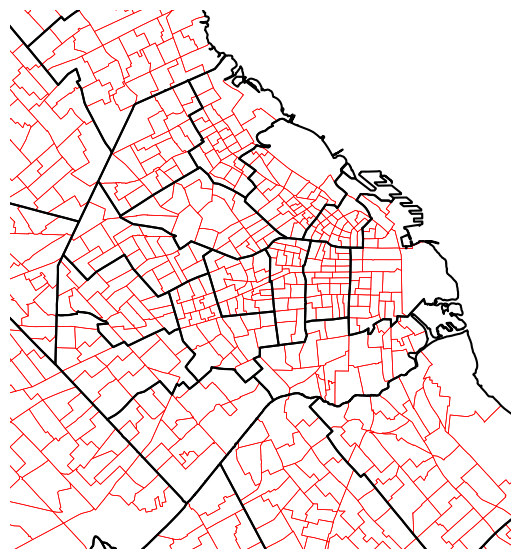

In [8]:
fig, ax = plt.subplots(1, figsize = (7, 7))

CONICET_fracs.plot(color = 'None', edgecolor = 'r', ax = ax, lw = .5)
CONICET_dptos.plot(color = 'None', edgecolor = 'k', ax = ax, lw = 1.5)

# plot bounds
custom_bounds = CONICET_dptos.loc[CONICET_dptos.PROV_ == '02'].total_bounds # CABA
x0, y0, x1, y1 = box(*custom_bounds).buffer(2000).bounds  ## 2km alrededor de CABA
# minx, miny, maxx, maxy

ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
ax.axis('off')

plt.show()

# Ejemplo, Deptos y Fracciones en zona CABA
